# Unsupervised learning

## Кластеризация

Задача кластеризации - разбить пространство объёктов на группы таким образом, чтобы одинаковые объекты были в одной группе, а разные объекты в разных группах

In [1]:
import os

import numpy as np

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  # гарантируем воспроизводимость

run_env = os.getenv('RUN_ENV', 'COLLAB')
if run_env == 'COLLAB':
  from google.colab import drive
  ROOT_DIR = '/content/drive'
  drive.mount(ROOT_DIR)
  print('Google drive connected')
  DRIVE_DATA_DIR = 'ml_course_data'
  root_data_dir = os.path.join(ROOT_DIR, 'MyDrive', DRIVE_DATA_DIR)
else:
  root_data_dir = os.getenv('DATA_DIR', '/srv/data')

if not os.path.exists(root_data_dir):
  raise RuntimeError('Отсутствует директория с данными')
else:
  print('Содержимое директории %s: %s', root_data_dir, os.listdir(root_data_dir)[:5])

Содержимое директории %s: %s /Users/adzhumurat/PycharmProjects/ai_product_engineer/data ['client_segmentation.csv', 'messages.db', 'labeled_data_corpus.csv', 'content_description.csv', 'nltk_data']


Как работает кластеризация

/var/folders/bd/bg2rzktd7cl7_q4_11m4dx7r0000gn/T/ipykernel_69761/3766988593.py:9: DeprecationWarning: numpy.core._multiarray_umath is deprecated and has been renamed to numpy._core._multiarray_umath. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core._multiarray_umath._reconstruct.
  data_clustering = pickle.load(f)


num points: 100


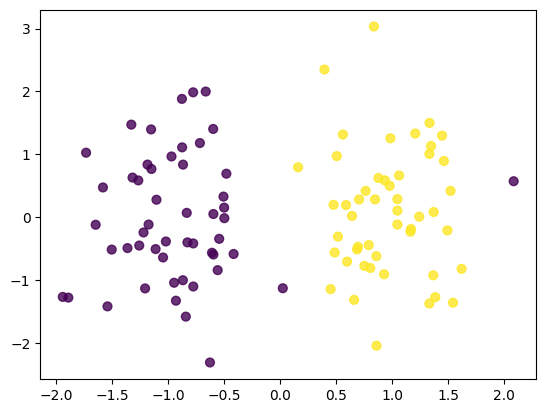

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

file_path = os.path.join(root_data_dir, 'clustering.pkl')

with open(file_path, 'rb') as f:
    data_clustering = pickle.load(f)
#  распаковываем данные
X = np.array(data_clustering['X'])
print('num points: %d' % X.shape[0])

Y = np.array(data_clustering['Y'])
# визуализация
plt.scatter(
    X[:, 0],
    X[:, 1], 
    s=40, c=Y, marker='o', alpha=0.8, label='data'
)
plt.show()

Видно, что данные разделены на два кластера. Кластера линейно не разделимы - мы видим один "выброс" (аутлаер)

Запускаем алгоритм кластеризации

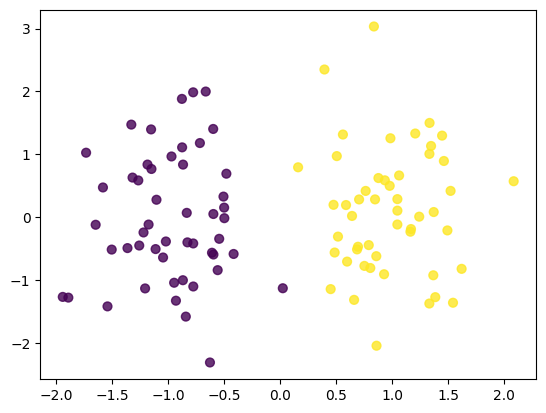

In [3]:
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=2, random_state=42)
kmeans_model.fit(X)

predicted_labels = kmeans_model.labels_
# визуализация
plt.scatter(
    X[:, 0],
    X[:, 1],
    s=40, c=predicted_labels, marker='o', alpha=0.8, label='data'
)
plt.show()

In [4]:
# kmeans_model = KMeans(n_clusters=3, random_state=42)
# kmeans_model.fit(X)

# predicted_labels = kmeans_model.labels_
# # визуализация
# plt.scatter(
#     X[:, 0],
#     X[:, 1],
#     s=40, c=predicted_labels, marker='o', alpha=0.8, label='data'
# )
# plt.show()

Видим, что аутлаер не "выявился", ну это скорее хорошо чем плохо

Каждый кластер характеризуется его центром. Центр кластера - среднее арифметическое  координат точек, которые входят в кластер

In [5]:
FIRST_CLUSTER_LABEL = 0
SECOND_CLUSTER_LABEL = 1

# Первый кластер
c_1 = X[
  np.where(predicted_labels==FIRST_CLUSTER_LABEL)
].mean(axis=0)

# Второй кластер
c_2 = X[
  np.where(predicted_labels==SECOND_CLUSTER_LABEL)
].mean(axis=0)

c_1, c_2

(array([-0.97742455, -0.03263543]), array([0.97792098, 0.10168404]))

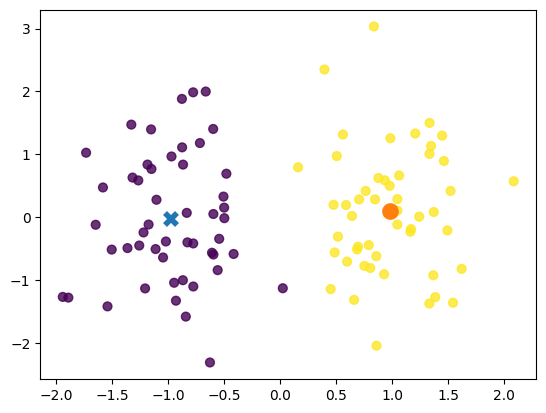

In [6]:
plt.scatter(X[:, 0], X[:, 1], s=40, c=predicted_labels, marker='o', alpha=0.8, label='data')
plt.plot(c_1[0], c_1[1], marker='x', mew=4, ms=8)
plt.plot(c_2[0], c_2[1], marker='o', mew=4, ms=8)
plt.show()

In [7]:
c_1

array([-0.97742455, -0.03263543])

**Задача**

Пусть центр

* Оставьте в датасете `X` только точки, которые соответствуют кластеру `Y==0` (c помощью `np.where`)
* посчитать сумму расстояний от каждой точки полученного датасета до центроида лейбла `c1 = [-0.97742455, -0.03263543]`
* округлите результат

Воспользуемся `from sklearn.metrics.pairwise.euclidean_distances`

Округлите результат `res` с помощью
```
np.round(res, 2)
```

Мы посчитаем т.н. сумму внутрикластерных расстояний - эта величина часто используется в метриках кластеризации

In [8]:
from sklearn.metrics.pairwise import euclidean_distances

#------ ВАШ КОД ТУТ ----------





#-------------------------------

### Вычислительная сложность

Применяют вычисление центроидов по подвыборке, такая модификация получила название **Mini batch K-mean**

### Инициализация центроидов

В зависимости от того, где расположаться центроиды при начальной инициализации зависит то, куда сойдётся алгоритм.

Выход - запустить алгоритм несколько раз. После нескольких запусков есть два варианта:

1. усреднить центроиды
2. Выбрать лучший по метрика качества (см. ниже)

### Выбор количества кластеров $k$

Существенный недостаток алгоритма заключается в необходимости до начала эксперимента выборать количество кластеров. Для подбора вводится метрика качества кластеризации с центроидами $\mu_k \forall k=1,\ldots,K$, которая измеряет внутрикластерное расстояние - насколько хорошо центр, который мы выбрали, совпадает с "идеальным" цетром кластера
$$
J(C) = \sum_{k=1}^{K}\sum_{j \in C_k} \mid x_i - \mu_k \mid \rightarrow min
$$

Очевидно, что эта метрика достигает оптимума в точке, где количество соответствует количеству элекментов в выборке. Однако, это вырожденый случай - на практике применяют эвристику "метод локтя"+ которая предполагает выбор точки, в которой резко снижается динамика изменения $J(C)$:
$$
D(K) =\frac{\mid J(C_{k+1}) - J(C_{k}) \mid}{\mid J(C_{k}) - J(C_{k-1}) \mid} \rightarrow \min
$$

step 0, cluster shift: [0.649759460820466, 0.7272905852269149]
step 1, cluster shift: [0.057076138803907286, 0.1185144254845458]
step 2, cluster shift: [0.027306580679466196, 0.05472543163770132]
step 3, cluster shift: [0.035876790063053304, 0.07623817888398844]
step 4, cluster shift: [0.058740960432993865, 0.11770532495739502]
step 5, cluster shift: [0.04220321660474325, 0.07321157432687547]
step 6, cluster shift: [0.05456532189177386, 0.08931155640548104]
step 7, cluster shift: [0.09196864061849042, 0.1270588712920236]
step 8, cluster shift: [0.08830401133426205, 0.10417867360640308]
step 9, cluster shift: [0.058147186316066336, 0.06682879090196275]


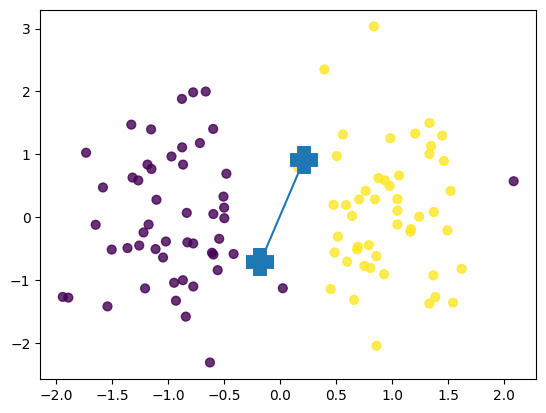

In [9]:
from scipy.spatial import distance

def k_means(X:np.array, k: int=2, eps: float=0.001, num_iteration: int=10, verbose: bool=True) -> np.array:
    """Алгоритм К-средних
    
    :param X: обучающая выборка
    :param k: количество кластеров
    """
    try:
        n, m = X.shape
    except ValueError:
        print("Обучающая выборка должна быть двумерным массивом (n, m) гдк m - размер выборки")
    # инициализируем центроиды случайным элементом выборки
    centroid_objects = [
        X[obj_id, :]
        for obj_id in np.random.randint(0, n, size=k)
    ]
    centroid_objects_prev = [np.zeros(m) for i in range(k)]
    # расстояние между предыдущим и текущим положением каждого центроида
    weight_evolution = [
        distance.euclidean(centroid_objects_prev[i], centroid_objects[i]) 
        for i in range(k)
    ]
    # условие остановки: центроиды не изменили своего положения
    step = 0
    # повторяем до выполнения условия остановки
    while sum(weight_evolution[i] > eps for i in range(k))!=0 and step < num_iteration:
        # иначе можно прострелить себе ногу =0
        centroid_objects_prev = centroid_objects.copy()
        # формируем матрицу (n x k), которая содержит расстояние от каждого объекта до каждого центроида
        # этот код можно переписать с использованием scipy.spatial.distance.cdist
        cluster_distance = np.hstack([
            np.sqrt(
                np.power(X - centroid, 2).sum(axis=1)
            ).reshape(-1,1)
            for centroid in centroid_objects
        ])
        # находим минимальное расстояние в каждой строчке - это будет кластер объекта
        cluster_lables = cluster_distance.argmin(axis=1)
        # усредняем координаты объектов каждого кластера - это новое положение центроида
        centroid_objects = [
            X[cluster_lables==i].mean(axis=0) for i in range(k)
        ]
        # вычисляем расстояние между центроидами на соседних итерациях
        weight_evolution = [
            distance.euclidean(centroid_objects_prev[j], centroid_objects[j]) 
            for j in range(k)
        ]
        if verbose:
            print("step %s, cluster shift: %s" % (step, weight_evolution))
        # обновлённые кластера
        step += 1
    return np.vstack(centroid_objects), cluster_lables
    

centroids, labels = k_means(X, k=2, num_iteration=10)

plt.scatter(X[:, 0], X[:, 1], s=40, c=Y, marker='o', alpha=0.8, label='data')
plt.plot(centroids[:, 0], centroids[:, 1], marker='+', mew=10, ms=20)
plt.show()

cluster_num 2, metric 103.60192927073518
cluster_num 3, metric 77.66103314941756
cluster_num 4, metric 67.32295182932836
Ошибка кластеризации cluster_num=5
cluster_num 6, metric 56.51513816339801
cluster_num 7, metric 52.23033225475773
best cluster num: 3


/var/folders/bd/bg2rzktd7cl7_q4_11m4dx7r0000gn/T/ipykernel_69761/1557954794.py:42: RuntimeWarning: Mean of empty slice.
  X[cluster_lables==i].mean(axis=0) for i in range(k)
/Users/adzhumurat/PycharmProjects/ai_product_engineer/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


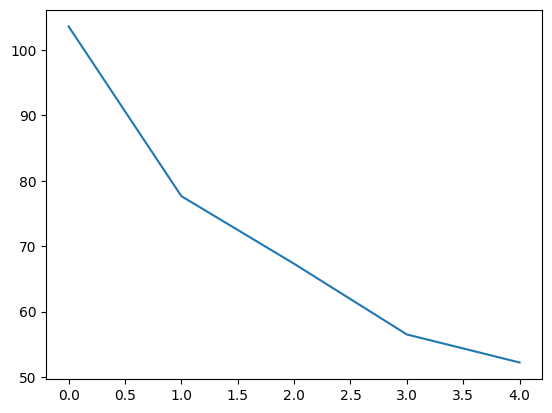

In [10]:
from sklearn.datasets import make_classification
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def J(centroid: np.array, sample: np.array) -> float:
    """Вычисляем качество кластера
    
    """
    return np.sqrt(
        np.power(
            sample - centroid, 2
        ).sum(axis=1)
    ).sum()

X_3, Y_3 = make_classification(
    n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=3
)

metrics = []
MAX_CLUSTERS = 8
for cluster_num in range(2, MAX_CLUSTERS):
    try:
        centroids, labels = k_means(X_3, k=cluster_num, num_iteration=10, verbose=False)
        metric = sum(
            J(centroids[centroid_label], X_3[labels==centroid_label])
            for centroid_label in range(cluster_num)
        )
        print("cluster_num %s, metric %s" % (cluster_num, metric))
        metrics.append(metric)
    except ValueError:
        print("Ошибка кластеризации cluster_num=%s" % cluster_num)


D = [abs(metrics[i+1]-metrics[i])/abs(metrics[i]-metrics[i-1])
     for i in range(1, len(metrics)-1)]
print("best cluster num: %s" % (np.argmin(D)+1))

#plt.scatter(X[:, 0], X[:, 1], s=40, c=Y, marker='o', alpha=0.8, label='data')
plt.plot(metrics)
plt.show()

# Гео данные

Данные по вызовас такси в городе [Johor Bahru](https://www.google.com/maps/place/Джохор-Бару,+Джохор,+Малайзия/@1.5448504,103.5695405,11z/data=!3m1!4b1!4m5!3m4!1s0x31da12c6d36b3a27:0xd5f4b21db593d4f5!8m2!3d1.492659!4d103.7413591)

In [11]:
import pandas as pd

geo_data_path = os.path.join(root_data_dir, 'geo_points.csv.gzip')

geo_points_df = pd.read_csv(geo_data_path, compression='gzip')
print('num_rows: %d' % geo_points_df.shape[0])

num_rows: 20000


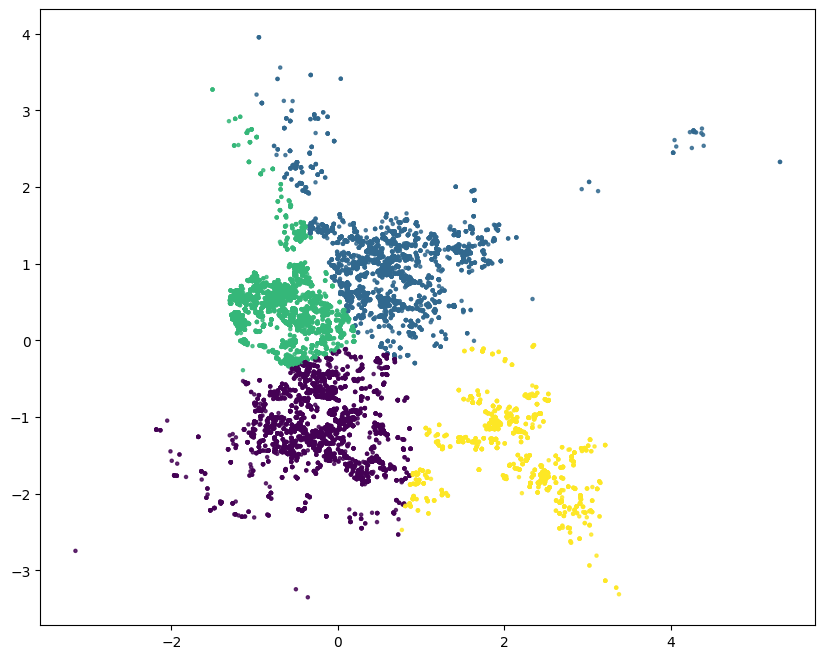

In [12]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(10, 8), dpi=100)

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def plot_data(X, labels):
  plt.scatter(
      X[:, 0],
      X[:, 1],
      s=5, c=predicted_labels, marker='o', alpha=0.8, label='data'
  )
  plt.show()

X = geo_points_df[['fromlatitude', 'fromlongitude']].values
X = StandardScaler().fit_transform(X)

kmeans_model = KMeans(n_clusters=4, random_state=42)
kmeans_model.fit(X)

predicted_labels = kmeans_model.labels_

plot_data(X, predicted_labels)

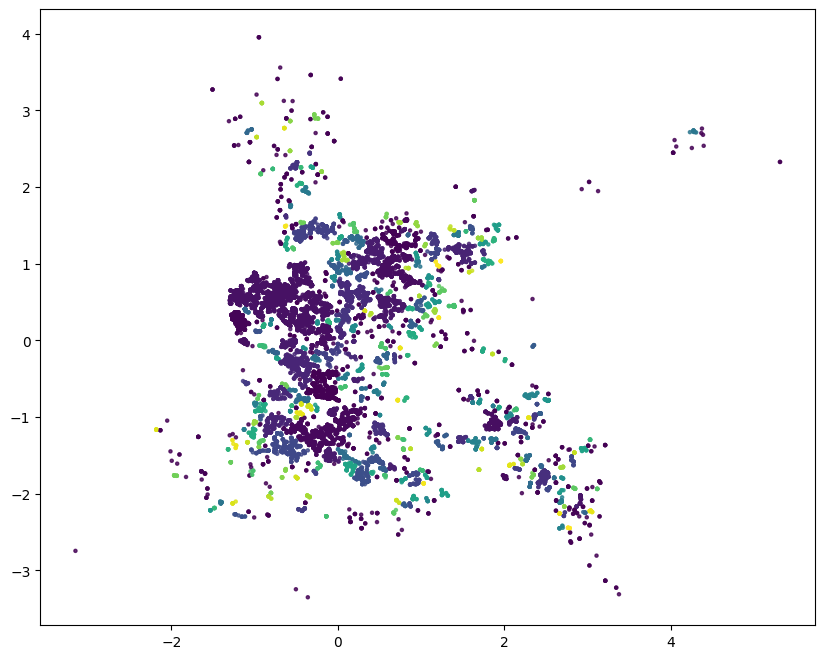

In [13]:
from sklearn.cluster import DBSCAN

figure(figsize=(10, 8), dpi=100)

X = geo_points_df[['fromlatitude', 'fromlongitude']].values
X = StandardScaler().fit_transform(X)
clustering = DBSCAN(
    eps=0.05, min_samples=6
).fit(X)
predicted_labels = clustering.labels_

plot_data(X, predicted_labels)

/Users/adzhumurat/PycharmProjects/ai_product_engineer/.venv/lib/python3.12/site-packages/sklearn/cluster/_optics.py:1083: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


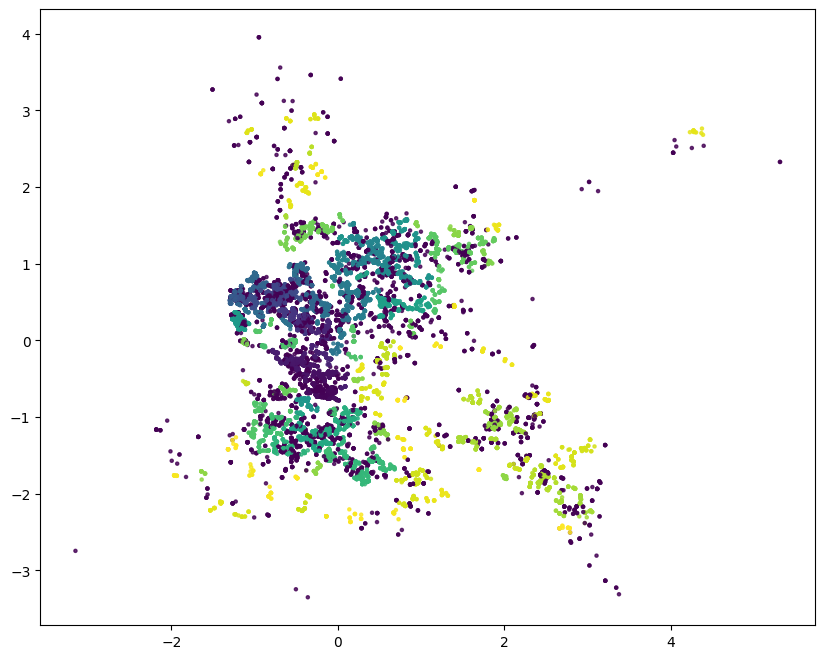

In [14]:
from sklearn.cluster import OPTICS

figure(figsize=(10, 8), dpi=100)

X = geo_points_df[['fromlatitude', 'fromlongitude']].values
X = StandardScaler().fit_transform(X)
clustering = OPTICS(max_eps=0.1, min_samples=10).fit(X)
predicted_labels = clustering.labels_

plot_data(X, predicted_labels)

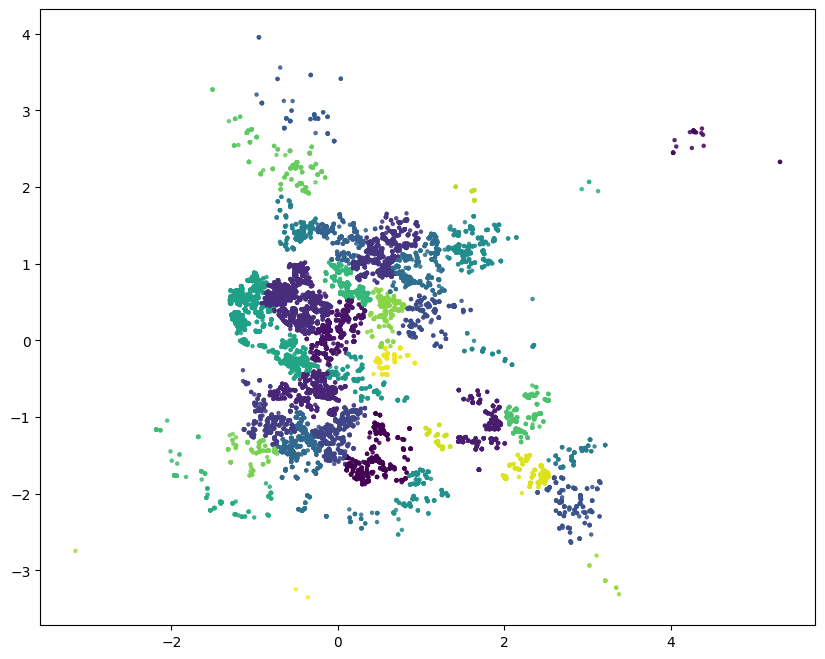

In [15]:
from sklearn.cluster import Birch

figure(figsize=(10, 8), dpi=100)

X = geo_points_df[['fromlatitude', 'fromlongitude']].values
X = StandardScaler().fit_transform(X)
clustering = Birch(threshold=0.05, branching_factor=10, n_clusters=40).fit(X)

predicted_labels = clustering.labels_

plot_data(X, predicted_labels)

## Снижение размерности

### Алгоритм PCA

Загрузим модельные данные

/var/folders/bd/bg2rzktd7cl7_q4_11m4dx7r0000gn/T/ipykernel_69761/3974220159.py:9: DeprecationWarning: numpy.core._multiarray_umath is deprecated and has been renamed to numpy._core._multiarray_umath. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core._multiarray_umath._reconstruct.
  X = pickle.load(f)


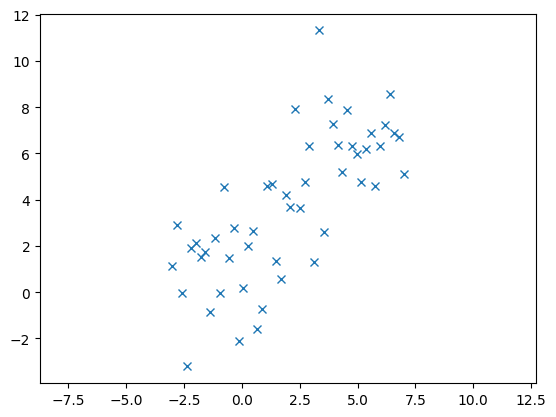

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

file_path = os.path.join(root_data_dir, 'eigen.pkl')

with open(file_path, 'rb') as f:
    X = pickle.load(f)

plt.plot(X[:,0], X[:,1], 'x')
plt.axis('equal')
plt.show()

Применяем алгоритм `sklearn.decomposition.PCA` к набору данных:

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
X_pca[:10]

array([[-5.28331909],
       [-3.84284422],
       [-5.88859559],
       [-8.07409089],
       [-4.16799935],
       [-3.8592636 ],
       [-4.17040423],
       [-3.86884344],
       [-5.65483844],
       [-3.16278418]])

Мы сжали с помощью PCA двумерные данные в одномерный массив. 

![pca_arrays](img/pca_arrays.png)

Давайте визуализируем этот массив - для этого надо произвести обратное преобразование из одномерного массива в двумерный. Отобразим "восстановленные" данные на графике (вторая картинка - исходный, не сжатый массив):

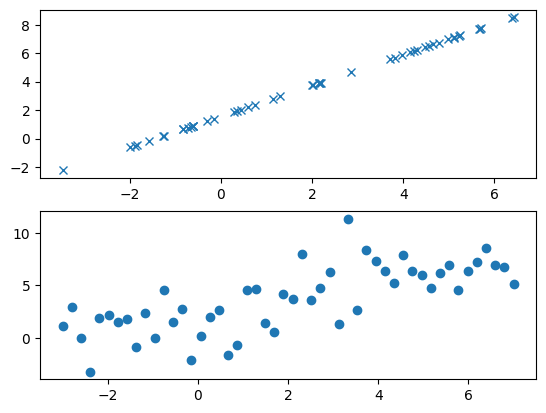

In [18]:
X_new = pca.inverse_transform(X_pca)

plt.figure(1)
plt.subplot(211)
plt.plot(X_new[:,0], X_new[:,1], 'x')

plt.subplot(212)
plt.plot(X[:,0], X[:,1], 'o')
plt.show()

Функция `inverse_transform` перереводит из одномерного пространства обратно в двумерное

Видно, что мы потеряли часть информации (меньше дисперсия - меньше информации в данных)

Алгоритм PCA выявил, что переменная от $x_2$ линейным образом зависит от переменной $x_1$ - то есть вместо перемнной $x_2$ можно использовать линейное преобразование $x_2 = x_1w_1 + w_0$ (эта переменная на первом графике). "Сжатые данные" представляют собой график линейной функции $x_2 = ax_1 + b$. 

Данные, представляли собой облако точек, но алгорим PCA ужал их до одномерного случая. Другие интересные визуализации можно [глянуть по ссылке](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html)

### Применение к реальным задачам

Снижение размерности применяем, чтобы "облегчить жизнь" алгоритмам машинного обучения. Иногда на данных большой размерности сложно хороший результат получить, а после снижения размерности качество модели улучшается

Применим PCA трехмерным данным по оттоку, которые содержатся в файле `data/client_segmentation.csv`. В файле содержится информация по клиентам оператора связи о том, как изменилось потребление услуг оператора за два месяца:
* call_diff доля звонков
* sms_diff доля смс
* доля интернет-трафика traffic_diff'

Этот датасет уже разбирали на лекции по классификации

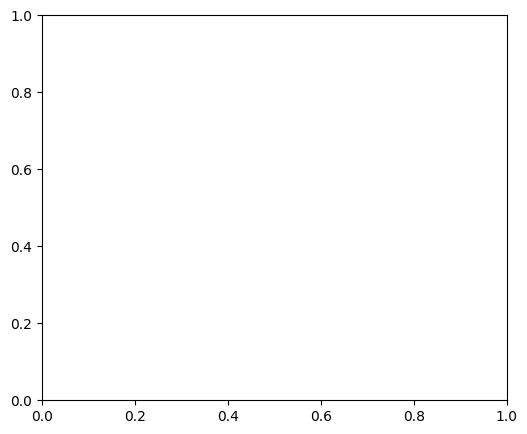

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

file_path = os.path.join(root_data_dir, 'client_segmentation.csv')

df_source = pd.read_csv(file_path)

X = df_source[['call_diff','sms_diff','traffic_diff']].values
y = df_source.customes_class.values
# и визуализируем их
fig = plt.figure(1, figsize=(6, 5))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134); plt.cla()
num_labels = np.unique(y).size
for name, label in [('class_%d' % i, i) for i in range(num_labels)]:
    ax.text3D(X[y == label, 0].mean(), X[y == label, 1].mean() + 0.5,
        X[y == label, 2].mean(), name, horizontalalignment='center',
        bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
# ax.w_xaxis.set_ticklabels([]); ax.w_yaxis.set_ticklabels([]); ax.w_zaxis.set_ticklabels([])
plt.show()

Сжимаем данные и визуализируем

In [20]:
X.shape

(100, 3)

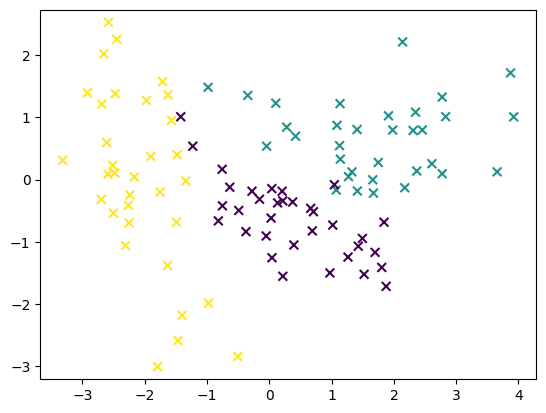

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(X)
X_pca = pca.transform(X)

plt.scatter(X_pca[:,0], X_pca[:,1], s=40, c=y, marker='x')
plt.axis('equal')
plt.show()

In [22]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

def eval_model(input_x, input_y):
    """Обучаем и валидируем модель"""
    X_train, X_test, y_train, y_test = train_test_split(
        input_x, input_y, test_size=.3, stratify=input_y, random_state=RANDOM_SEED
    )
    # Для примера возьмём неглубокое дерево решений
    clf = DecisionTreeClassifier(max_depth=2, random_state=42)
    clf.fit(X_train, y_train)
    preds = clf.predict_proba(X_test)
    acc_score = accuracy_score(y_test, preds.argmax(axis=1))
    print('Accuracy: %.5f' % acc_score)


Вычисляем скор по исходным данным

In [23]:
X = df_source[['call_diff','sms_diff','traffic_diff']].values
y = df_source.customes_class.values

eval_model(X, y)

Accuracy: 0.80000


Применяем преобразование и снова решаем задачку классификации

In [24]:
eval_model(X_pca, y)

Accuracy: 0.83333


**Вывод**: удалось улучшить качество на "слабой" модели решающего дерева за счёт снижения размерности входных данных 

### Алгоритм umap

Ниболее мощный алгоритм для снижения размерности

In [25]:
from IPython.display import clear_output
!pip install umap-learn

clear_output()

In [26]:
from umap import UMAP

In [27]:
manifold = UMAP(
    random_state=RANDOM_SEED, n_components=2
).fit(X, y)
X_umap = manifold.transform(X)

/Users/adzhumurat/PycharmProjects/ai_product_engineer/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Визуализируем данные

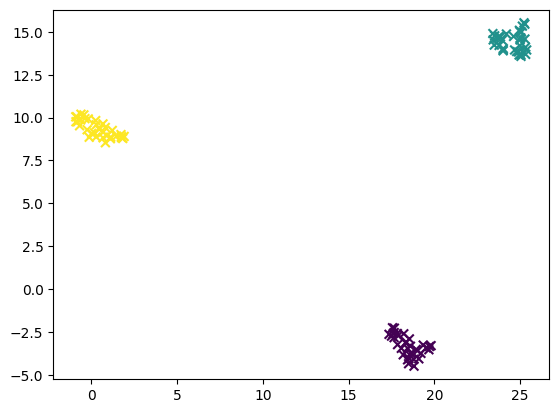

In [28]:
plt.scatter(X_umap[:,0], X_umap[:,1], s=40, c=y, marker='x')
plt.axis('equal')
plt.show()

In [29]:
eval_model(X_umap, y)

Accuracy: 1.00000


Данные стали линейно разделимы, качество потрясающее даже на слабом алгоритме. Подробнее можно почитать в [статье](https://towardsdatascience.com/tsne-vs-umap-global-structure-4d8045acba17)

### Снижаем размерность изображений

До сих пор мы работали с табличными данными, для разнообразия можно немного поработать с изображениями (похожий трюк можно увидеть в этой [статье на хабре](https://habr.com/ru/post/275273/)). Для этого нужно установить модуль Pillow (если у вас Анаконда, то https://anaconda.org/anaconda/pillow)

```shell
pip install Pillow
```

In [30]:
pip install Pillow
clear_output()

SyntaxError: invalid syntax (1792298941.py, line 1)

In [ ]:
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg

file_path = os.path.join(root_data_dir, 'gray_goose.jpg')
img = mpimg.imread(file_path)

imshow(img)
plt.show()

У нас трёхмерный массив, где третье измерение соответствует цветовой компоненте rgb. Цветную картинку можно преобразовать в двумерную серую (grayscale) однотонную с помощью формулы, которую я нашёл [тут](https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python) 

Однотонная картинка - это по сути матрица, где на пересечении строки и столбца находится яркость пикселя

In [ ]:
def rgb2gray(rgb):
    tile = np.tile(np.c_[0.333, 0.333, 0.333], reps=(rgb.shape[0],rgb.shape[1],1))
    return np.sum(tile * rgb, axis=2)

img_gray = rgb2gray(img)

# демонстрируем, что у нас матрица размерности 202 x 310
print(type(img_gray), img_gray.shape)

imshow(img_gray, cmap = "gray")
plt.show()

In [ ]:
img_gray.shape

Далее 

* обучите на массиве *img_gray* размерности $202 \times 310$ класс TruncatedSVD c параметром n_components=5
* получите матрицу *img_gray_svd* с помощью функции `transform`
* получите массив *img_gray_svd_restored* с помощью функции `inverse_transform`
* визуализируйте массив *img_gray_svd_restored* с помощью функции *imshow*

Этот алгоритм демонстрирует, как происходит сжатие данных большой размерности. А результате у вас должен получиться гусь как бы в очень нечётком виде


In [ ]:
from sklearn.decomposition import TruncatedSVD